In [ ]:
# !pip install transformers torch umap-learn pillow numpy matplotlib pandas pylabeladjust

In [34]:
import torch
import numpy as np
import os
import pickle
import shutil
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from transformers import CLIPImageProcessor, CLIPModel


In [27]:

# path to the folder with images generated by vikus-viewer-script (1024)
image_path = 'vikus-viewer/data/1024/'
# batch_size for CLIP depends on your GPU memory
batch_size = 10

def create_embeddings(image_folder, batch_size=10):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # MPS for Metal Performance Shaders on macOS
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")

    model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
    processor = CLIPImageProcessor.from_pretrained('openai/clip-vit-base-patch32')

    embeddings = {}

    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    
    #image_files = image_files[:20]

    for i in tqdm(range(0, len(image_files), batch_size)):
        batch_files = image_files[i:i + batch_size]
        batch_images = []
        valid_indices = []

        for j, image_file in enumerate(batch_files):
            this_image_path = os.path.join(image_folder, image_file)

            try:
                image = Image.open(this_image_path)
                #image = image.resize((224, 224))
            except UnidentifiedImageError:
                print(f"Invalid image file: {this_image_path}")
                invalid_folder = os.path.join(os.path.dirname(image_folder), 'invalid')
                if not os.path.exists(invalid_folder):
                    os.mkdir(invalid_folder)
                shutil.move(this_image_path, os.path.join(invalid_folder, image_file))
                continue

            batch_images.append(image)
            valid_indices.append(j)

        inputs = processor(batch_images, return_tensors="pt", padding=True)
        inputs = inputs.to(device)

        with torch.no_grad():
            batch_embeddings = model.get_image_features(**inputs).cpu().numpy()

        for j, image_file in enumerate(batch_files):
            if j not in valid_indices:
                continue

            image_id = os.path.splitext(image_file)[0]
            embeddings[image_id] = batch_embeddings[valid_indices.index(j)]

    return embeddings

embeddings = create_embeddings(image_path, batch_size)


Using device: mps


100%|██████████| 102/102 [00:15<00:00,  6.53it/s]


In [28]:
# save embeddings if you want to use them later
with open('clip-embeddings.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [29]:
# load embeddings if you have already created them
import pickle
with open('clip-embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

In [42]:
# use umap to reduce dimensionality to 2D
import umap
import numpy as np

reducer = umap.UMAP(random_state=42, min_dist=0.05, n_neighbors=50)
embedding = np.array(list(embeddings.values()))
embedding = embedding.reshape((embedding.shape[0], -1))
embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
embedding = reducer.fit_transform(embedding)


/Users/Noich001/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


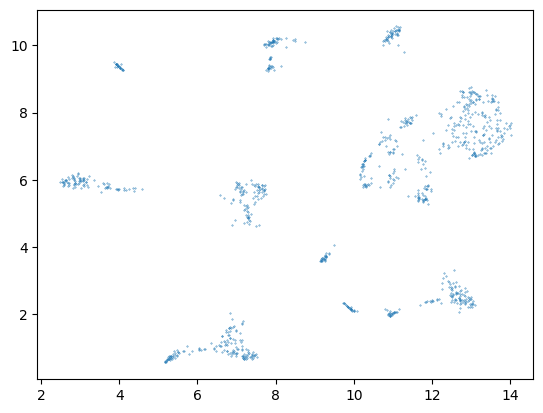

In [43]:
# plot embeddings
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1)


We can now go on to push the images apart using pylabeladjust:

In [44]:
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler


# First we have to get the sizes of the images:
image_sizes = []

for ix,filename in enumerate(os.listdir(image_path)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        this_image_path = os.path.join(image_path, filename)
        image = Image.open(this_image_path)
        width, height = image.size
        image_sizes.append((embedding[ix,0],embedding[ix,1],width, height))

rectangles = pd.DataFrame(image_sizes, columns=["x","y","width", "height"])
rectangles_standardized = rectangles.copy()


scaler = StandardScaler()
scale_factor=.05

# First we standardize the x and y coordinates:
rectangles_standardized[['x','y']] = scaler.fit_transform(rectangles_standardized[['x','y']])


# Then we rescale the sizes reative to the extent of a standardized embedding, using our scale factor:
rectangles_standardized[['width','height']] = rectangles_standardized[['width','height']] / rectangles_standardized[['width','height']].max(axis=0) * scale_factor

# We then bring all size to encompass the same area. This makes smaller and larger images more comparable in the final embedding.
# We won't want that for all use-cases, but it's nice for looking at collections.
rectangles_standardized['original_area'] = rectangles_standardized['width'] * rectangles_standardized['height']
target_area = rectangles_standardized['original_area'].median()
rectangles_standardized['scaling_factor'] = (target_area / rectangles_standardized['original_area']) ** 0.5
rectangles_standardized['width'] = rectangles_standardized['width'] * rectangles_standardized['scaling_factor']
rectangles_standardized['height'] = rectangles_standardized['height'] * rectangles_standardized['scaling_factor']

# We drop the temporary columns used for calculations
rectangles_standardized.drop(columns=['original_area', 'scaling_factor'], inplace=True)


display(rectangles_standardized.head())

,x,y,width,height
0,-0.061831,-0.646391,0.050488,0.035155
1,-1.552722,0.054856,0.034180,0.051929
2,0.359539,0.276307,0.060171,0.029498
3,0.430037,0.419490,0.059814,0.029674
4,1.220929,0.561560,0.049227,0.036055


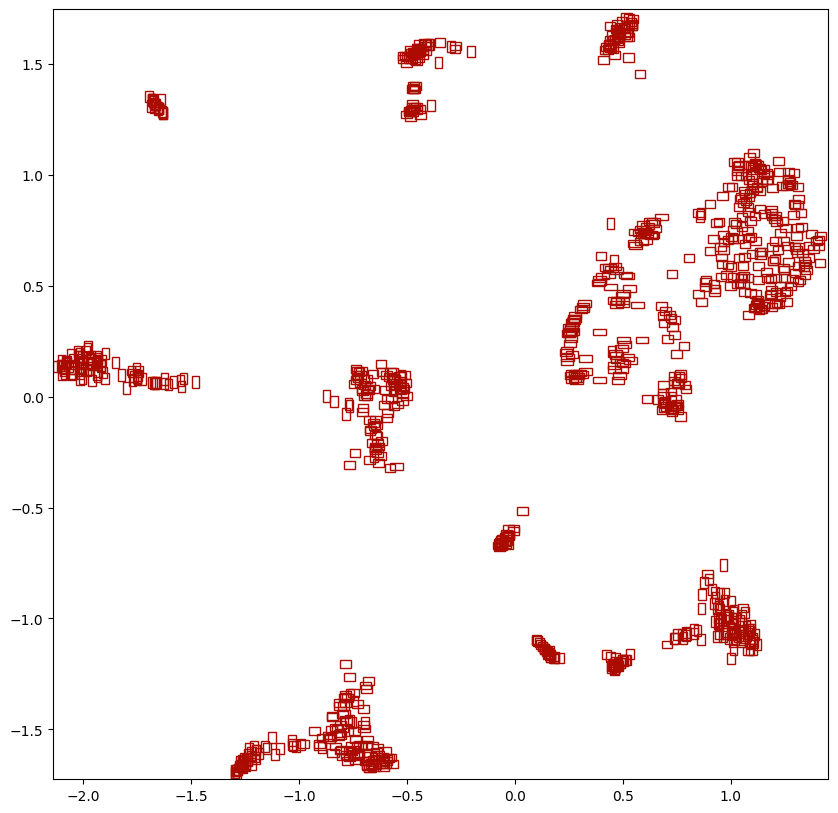

In [45]:
#We can plot the initial layout with pylabeladjust:

from pylabeladjust import adjust_labels,adjust_texts,plot_rectangles
fig, ax = plt.subplots(figsize=(10,10))
plot_rectangles(ax,rectangles_standardized,color= '#ab0b00')
plt.show()

In [46]:
rectangles_adjusted = adjust_labels(rectangles_standardized,
                                  
                                  #  speed=.01,
                                    adjust_by_size=True,
                                    radius_scale=1.1,
                                    max_iterations=250,
                                    margin_percentage=20,
                                    return_optimization_process=False)



  0%|          | 0/250 [00:00<?, ?it/s]

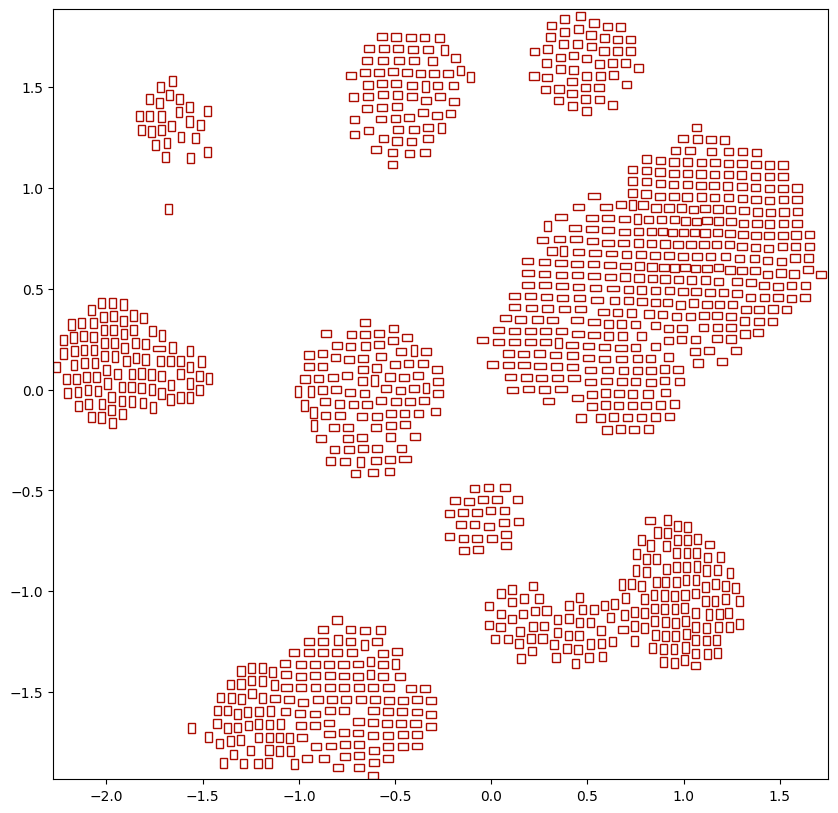

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
plot_rectangles(ax,rectangles_adjusted,color= '#ab0b00')
plt.show()

In [48]:
# export to csv for visualization with vikus-viewer
import pandas as pd

df = rectangles_adjusted[['x', 'y']]
df['id'] = list(embeddings.keys())
df.to_csv("projection.csv")

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_35274/3152037373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = list(embeddings.keys())
